In [1]:
! pip install yfinance
! pip install textblob
! pip install vaderSentiment
! pip install nltk

In [2]:
import yfinance as yf
import os, contextlib
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch import nn
from d2l import torch as d2l
import nltk
nltk.download('punkt')
import time
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ccm51\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
dataset1 = pd.read_csv(r"C:\Users\ccm51\Documents\ECGR-4106\Final Project\news-top-25.csv", encoding='unicode_escape')
dataset2 = pd.read_csv(r"C:\Users\ccm51\Documents\ECGR-4106\Final Project\news-April_1st_2020.csv", encoding='unicode_escape')

In [4]:
dataset_labels = pd.read_csv(r"C:\Users\ccm51\Documents\ECGR-4106\Final Project\labels.csv")
dataset_aapl = pd.read_csv(r"C:\Users\ccm51\Documents\ECGR-4106\Final Project\stocks\AAPL.csv")

In [5]:
dataset1.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top22,Top23,Top24,Top25,Combined News,Subjectivity,Polarity,Negativity,Neutrality,Positivity
0,1/3/2000,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title,NaN,NaN,NaN,NaN,NaN,NaN
1,1/4/2000,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite,NaN,NaN,NaN,NaN,NaN,NaN
2,1/5/2000,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# for i in range(len(dataset_labels)):
#     print(dataset_labels["Label"][i], dataset_labels["Label"][i]==0, dataset_labels["Label"][i]==1)

In [7]:
dataset2.head(3)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/jimmy-kimmel-co...,Jimmy Kimmel Offers Up Some Hilariously Terrib...,ENTERTAINMENT,The late night talk show host shared some âs...,Ed Mazza,4/1/2020
1,https://www.huffpost.com/entry/wayne-brady-cor...,Wayne Brady Is In Quarantine With His Ex-Wife ...,ENTERTAINMENT,The Emmy winner said he and Mandie Taketa have...,Curtis M. Wong,4/1/2020
2,https://www.huffpost.com/entry/stoner-movies-n...,8 Of The Best Stoner Movies And Shows To Watch...,HOME & LIVING,Netflix and super chill on the upcoming 4/4/2020.,Todd Van Luling,4/1/2020


In [8]:
dataset2_org = {}

for row in range(0, len(dataset2.index)):
    if dataset2["date"][row] not in dataset2_org:
        headline = str(dataset2["headline"][row])
        cat = str(dataset2["category"][row])
        desc = str(dataset2["short_description"][row])
        data = headline + " " + cat + " " + desc
        dataset2_org[str(dataset2["date"][row])] = data
    else:
        headline = str(dataset2["headline"][row])
        cat = str(dataset2["category"][row])
        desc = str(dataset2["short_description"][row])
        data = headline + " " + cat + " " + desc
        dataset2_org[str(dataset2["date"][row])] = dataset2_org[str(dataset2["date"][row])] + " " + data
#         print(dataset2["date"][row], dataset2_org[str(dataset2["date"][row])])

In [9]:
# for key in dataset2_org:
#     data = re.sub("â", '"', dataset2_org[key])
#     data = re.sub("â", "'", data)
#     data = str(re.sub("\'", "", data))
#     dataset2_org[key] = data

In [10]:
dataset2_org['4/1/2020']

'Jimmy Kimmel Offers Up Some Hilariously Terrible Coronavirus April Fools\' Pranks ENTERTAINMENT The late night talk show host shared some â\x80\x9csimple ways to torment your loved ones" in the age of social distancing. Wayne Brady Is In Quarantine With His Ex-Wife And Her Boyfriend During Coronavirus ENTERTAINMENT The Emmy winner said he and Mandie Taketa have formed a "new nuclear family" in order to co-parent their 17-year-old daughter while self-isolating. 8 Of The Best Stoner Movies And Shows To Watch High On Netflix HOME & LIVING Netflix and super chill on the upcoming 4/4/2020. How Long Can Asymptomatic Coronavirus Carriers Infect Others? WELLNESS This is what we know about COVID-19 disease spread from people who appear to be healthy. MyPillow CEO Rants Against \'Evil\' Media For Coverage Of His White House Briefing POLITICS Mike Lindell praised God for Trump\'s election and told Americans to read the Bible at a coronavirus briefing. Howard Stern Nails Trump\'s Problem: \'Doesn

In [11]:
org_dataset = dataset2_org

for row in range(0, len(dataset1.index)):
    if dataset1["Date"][row] not in org_dataset:
        org_dataset[str(dataset1["Date"][row])] = ""
    for n in range(1, 26):
        string = "Top" + str(n)
        org_dataset[str(dataset1["Date"][row])] = str(org_dataset[str(dataset1["Date"][row])]) + " " + str(dataset1[string][row])

In [12]:
for key in org_dataset:
    data = re.sub("â", '"', org_dataset[key])
    data = re.sub("â", "'", data)
    data = re.sub("â", '"', data)
    data = re.sub("Â\xa0", '', data)
    data = re.sub("â\x80\x90", '', data)
    data = re.sub("â\x80\x91", '', data)
    data = re.sub("â\x80\x92", '', data)
    data = re.sub("â\x80\x93", '', data)
    data = re.sub("â\x80\x94", '', data)
    data = re.sub("â\x80\x95", '', data)
    data = re.sub("â\x80\x96", '', data)
    data = re.sub("â\x80\x97", '', data)
    data = re.sub("â\x80\x98", '', data)
    data = re.sub("â\x80\x99", '', data)
    data = re.sub("â\x80\x9a", '', data)
    data = re.sub("â\x80\x9b", '', data)
    data = re.sub("â\x80\x9c", '', data)
    data = re.sub("â\x80\x9d", '', data)
    data = re.sub("â\x80\x9e", '', data)
    data = re.sub("â\x80\x9f", '', data)
    data = re.sub("Ã©", 'a', data)
    data = re.sub("b'", "", data)
    data = re.sub("b[(')]", "", data)
    data = re.sub('b[(")]', "", data)
    data = re.sub("' b", "", data)
    data = re.sub('" b', "", data)
    data = re.sub("\'", "", data)

    org_dataset[key] = data

In [13]:
org_dataset["4/1/2020"]

'Jimmy Kimmel Offers Up Some Hilariously Terrible Coronavirus April Fools Pranks ENTERTAINMENT The late night talk show host shared some "simple ways to torment your loved ones" in the age of social distancing. Wayne Brady Is In Quarantine With His Ex-Wife And Her Boyfriend During Coronavirus ENTERTAINMENT The Emmy winner said he and Mandie Taketa have formed a "new nuclear family" in order to co-parent their 17-year-old daughter while self-isolating. 8 Of The Best Stoner Movies And Shows To Watch High On Netflix HOME & LIVING Netflix and super chill on the upcoming 4/4/2020. How Long Can Asymptomatic Coronavirus Carriers Infect Others? WELLNESS This is what we know about COVID-19 disease spread from people who appear to be healthy. MyPillow CEO Rants Against Evil Media For Coverage Of His White House Briefing POLITICS Mike Lindell praised God for Trumps election and told Americans to read the Bible at a coronavirus briefing. Howard Stern Nails Trumps Problem: Doesnt Give One S**t Abou

In [14]:
dataset1["Combined News"] = ""

for key in org_dataset:
    for i in range(0, len(dataset1["Date"])):
        if str(key) == str(dataset1["Date"][i]):
            dataset1["Combined News"][i] = org_dataset[key]

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1["Combined News"][i] = org_dataset[key]
C:\Users\ccm51\AppData\Local\Temp\ipykernel_11988\1219491698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

In [15]:
n = 0
for i in range(0, len(dataset1["Combined News"])):
    n += len(dataset1["Combined News"][i].split())
print(f"There are {n} tokens in this dataset.")

There are 4947418 tokens in this dataset.


In [16]:
dataset1.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top22,Top23,Top24,Top25,Combined News,Subjectivity,Polarity,Negativity,Neutrality,Positivity
0,1/3/2000,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title,A hindrance to operations: extracts from the ...,NaN,NaN,NaN,NaN,NaN
1,1/4/2000,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite,Scorecard The best lake scene Leader: German ...,NaN,NaN,NaN,NaN,NaN
2,1/5/2000,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links,Coventry caught on counter by Flo Uniteds riv...,NaN,NaN,NaN,NaN,NaN


In [17]:
dataset1["Combined News"][2315]

' An Air France aircraft carrying 215 people has disappeared off the radar in the Atlantic Ocean off Brazil Can you tell the difference between an Israeli and a Palestinian?  Former German MP/Judge offers $1m reward for prosecution of Bush, Cheney, Rumsfeld, and Blair North Korea starts landing exercises using amphibious vessels - may be planning attack on South Korean island President of El Salvador sends son to France to escape the violence of his native El Salvador. Son is stabbed to death with an awl on a Parisian bridge in a random act of violence with no apparent motive. Indonesian model that married Malaysian prince says she was kidnapped, drugged and sexually abused by the royal family, escapes with help of Singaporean police "The Attack on the LIBERTY: The Untold Story of Israels Deadly 1967 Assault on a U.S. Spy Ship":A Book Review and More El Salvadors first leftist president takes power - Hillary Clinton attended the inauguration" Thousands of Indian farmers switching back 

In [18]:
def getScores(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return TextBlob(text).sentiment.subjectivity, TextBlob(text).sentiment.polarity, sentiment["neg"], sentiment["neu"], sentiment["pos"], sentiment["compound"]

In [19]:
dataset1["Subjectivity"] = ""
dataset1["Polarity"] = ""
dataset1["Negativity"] = ""
dataset1["Neutrality"] = ""
dataset1["Positivity"] = ""

for i in range(0, len(dataset1)):
    sub, pol, neg, neu, pos, _ = getScores(dataset1["Combined News"][i])
    dataset1["Subjectivity"][i] = sub
    dataset1["Polarity"][i] = pol
    dataset1["Negativity"][i] = neg
    dataset1["Neutrality"][i] = neu
    dataset1["Positivity"][i] = pos
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708


In [22]:
ls = dataset_labels.copy()

df = dataset1.copy()
cols = ["Subjectivity", "Polarity", "Negativity", "Neutrality", "Positivity"]
data = df[cols][-len(ls):]

In [39]:
print(data)

     Subjectivity  Polarity Negativity Neutrality Positivity
162      0.376768 -0.033081      0.163      0.726      0.111
163      0.339483  0.083512      0.086       0.82      0.093
164      0.302381  0.032937      0.042      0.829      0.129
165      0.206667     -0.02      0.137      0.807      0.056
166      0.553571 -0.007143      0.077       0.84      0.083
...           ...       ...        ...        ...        ...
4258     0.440061  0.064097      0.138      0.736      0.126
4259     0.437125  0.079775      0.132      0.723      0.145
4260     0.423265  0.078444      0.146      0.711      0.143
4261     0.425669  0.092289      0.142      0.741      0.117
4262      0.46766  0.079679      0.163      0.703      0.135

[4101 rows x 5 columns]


In [23]:
x = np.array(data)
y = np.array(ls)

In [34]:
i = 100
model = GaussianNB()
true_pos = np.zeros(i)
false_pos = np.zeros(i)
false_neg = np.zeros(i)
true_neg = np.zeros(i)

for n in range(i):
    np.random.seed(n)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2)
    model.fit(x_train, y_train)
    expected = y_test
    predicted = model.predict(x_test)
    print("Random Seed ", n)
    print(metrics.classification_report(expected, predicted))
    conM1 = metrics.confusion_matrix(expected, predicted)
    true_neg[n] = conM1[0, 0]
    false_neg[n] = conM1[1, 0]
    false_pos[n] = conM1[0, 1]
    true_pos[n] = conM1[1, 1]

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Random Seed  0
              precision    recall  f1-score   support

           0       0.46      0.12      0.19       393
           1       0.52      0.87      0.65       428

    accuracy                           0.51       821
   macro avg       0.49      0.49      0.42       821
weighted avg       0.49      0.51      0.43       821

Random Seed  1
              precision    recall  f1-score   support

           0       0.42      0.17      0.25       390
           1       0.51      0.78      0.62       431

    accuracy                           0.49       821
   macro avg       0.47      0.48      0.43       821
weighted avg       0.47      0.49      0.44       821

Random Seed  2
              precision    recall  f1-score   support

           0       0.46      0.16      0.24       391
           1       0.52      0.83      0.64       430

    accuracy                           0.51       821
   macro avg       0.49      0.50      0.44       821
weighted avg       0.49      

Random Seed  38
              precision    recall  f1-score   support

           0       0.64      0.02      0.03       398
           1       0.52      0.99      0.68       423

    accuracy                           0.52       821
   macro avg       0.58      0.50      0.36       821
weighted avg       0.58      0.52      0.37       821

Random Seed  39
              precision    recall  f1-score   support

           0       0.44      0.23      0.30       386
           1       0.52      0.74      0.61       435

    accuracy                           0.50       821
   macro avg       0.48      0.49      0.46       821
weighted avg       0.48      0.50      0.47       821

Random Seed  40
              precision    recall  f1-score   support

           0       0.52      0.16      0.25       404
           1       0.51      0.85      0.64       417

    accuracy                           0.51       821
   macro avg       0.51      0.51      0.44       821
weighted avg       0.51   

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Random Seed  74
              precision    recall  f1-score   support

           0       0.48      0.17      0.25       378
           1       0.54      0.84      0.66       443

    accuracy                           0.53       821
   macro avg       0.51      0.51      0.46       821
weighted avg       0.51      0.53      0.47       821

Random Seed  75
              precision    recall  f1-score   support

           0       0.44      0.19      0.27       379
           1       0.53      0.79      0.64       442

    accuracy                           0.52       821
   macro avg       0.49      0.49      0.45       821
weighted avg       0.49      0.52      0.47       821

Random Seed  76
              precision    recall  f1-score   support

           0       0.42      0.18      0.25       392
           1       0.51      0.77      0.61       429

    accuracy                           0.49       821
   macro avg       0.47      0.48      0.43       821
weighted avg       0.47   

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [35]:
avg_true_neg = sum(true_neg)/len(true_neg)
avg_true_pos = sum(true_pos)/len(true_pos)
avg_false_neg = sum(false_neg)/len(false_neg)
avg_false_pos = sum(false_pos)/len(false_pos)

In [40]:
print(f"""
The Average Recall, Precision, and \nAccuracy over {i+1} Iterations:
Recall = {round(avg_true_pos/(avg_true_pos + avg_false_neg), 5)}
Precision = {round(avg_true_neg/(avg_true_neg + avg_false_pos), 5)}
Accuracy = {round((avg_true_pos + avg_true_neg) / (avg_true_pos + avg_false_neg + avg_true_neg + avg_false_pos), 5)}
""")
conM1_avg = [[avg_true_neg, avg_false_pos], [avg_false_neg, avg_true_pos]]


The Average Recall, Precision, and 
Accuracy over 101 Iterations:
Recall = 0.83867
Precision = 0.14316
Accuracy = 0.50669



Text(0.5, 427.9555555555555, 'Predicted Label')

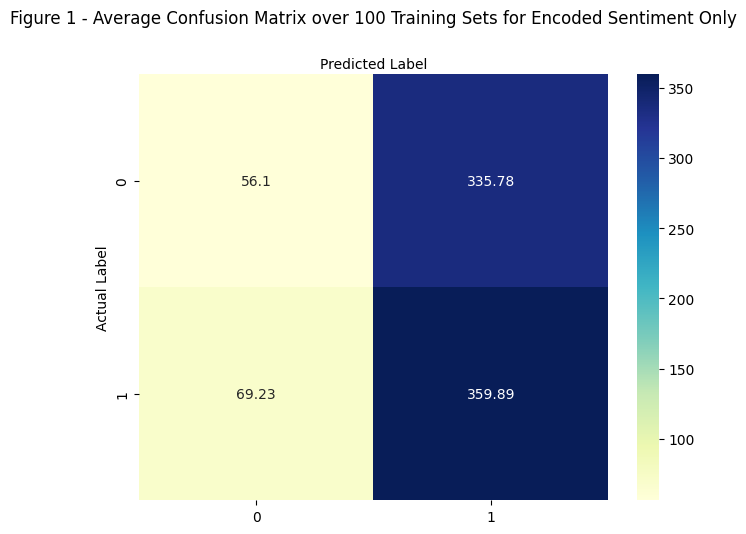

In [37]:
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(conM1_avg), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Figure 1 - Average Confusion Matrix over 100 Training Sets for Encoded Sentiment Only", y=1.1)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

In [28]:
appl_str = """
Disney CEO Bob Iger says Disney+ is on a path towards profitability despite subscriber loss. 
FAANG stocks could soar up to 50% this year, says Fundstrat’s Tom Lee. 
Goldman says buybacks are on pace to tumble, but 2 stocks are bucking the trend. 
Wednesday, May 10, 2023: Why Cramer is bearish on an entertainment portfolio stock. 
Wednesday’s top analyst calls: Apple, Tesla, Walmart, Chevron, Lumentum, Rivian. 
Microsoft ramps up A.I. game with bet on ‘no-code’ startup Builder.ai. 
Skyworks Solutions slumps on Q3 guidance. Here’s what experts say to do next. 
Tuesday, May 9, 2023: Cramer is looking to add to this retail name. 
GM hires ex-Apple exec to lead new software unit. 
Tuesday’s biggest analyst calls: Microsoft, Apple, Alphabet, JPMorgan, PayPal. 
A.I. trade is leaving investors vulnerable to painful losses: Evercore. 
Jim Cramer makes a case for Apple being considered a consumer product company. 
1 in 3 investors expect markets to fall 10% in next three months, according to Investopedia survey. 
Here’s what’s killing PayPal’s growth. 
"""
subjectivity, polarity, negativity, neutrality, positivity, _ = getScores(appl_str)
ex = np.array([subjectivity, polarity, negativity, neutrality, positivity]).reshape(1, -1)

In [29]:
print(model.predict(ex))

[1]


In [30]:
aapl = dataset_aapl.copy()
cols2 = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data_aapl = aapl[cols2][-len(ls):]

In [38]:
print(data_aapl)

            Open        High         Low       Close   Adj Close     Volume
5808    1.442143    1.463571    1.429286    1.437143    1.247499   93489200
5809    1.434286    1.437857    1.413571    1.420000    1.232618   68565000
5810    1.421429    1.441429    1.421429    1.431429    1.242538   82728800
5811    1.442143    1.458571    1.401429    1.407143    1.221457  113390200
5812    1.403571    1.420714    1.375000    1.417857    1.230758   94266200
...          ...         ...         ...         ...         ...        ...
9904  246.520004  258.679993  246.360001  258.440002  258.440002   63021800
9905  252.750000  255.869995  247.050003  247.740005  247.740005   51054200
9906  250.740005  255.520004  249.399994  254.809998  254.809998   41994100
9907  255.600006  262.489990  252.000000  254.289993  254.289993   49250500
9908  246.500000  248.720001  239.130005  240.910004  240.910004   43956200

[4101 rows x 6 columns]


In [31]:
a = np.array(data_aapl)
i = 100
model = LinearDiscriminantAnalysis()
true_pos = np.zeros(i)
false_pos = np.zeros(i)
false_neg = np.zeros(i)
true_neg = np.zeros(i)

for n in range(i):
    np.random.seed(n)
    a_train, a_test, y_train, y_test = train_test_split(a, y, train_size = 0.8, test_size = 0.2)
    model.fit(a_train, y_train)
    expected = y_test
    predicted = model.predict(a_test)
    print("Random Seed ", n)
    print(metrics.classification_report(expected, predicted))
    conM1 = metrics.confusion_matrix(expected, predicted)
    true_neg[n] = conM1[0, 0]
    false_neg[n] = conM1[1, 0]
    false_pos[n] = conM1[0, 1]
    true_pos[n] = conM1[1, 1]

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarni

Random Seed  0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.52      1.00      0.69       428

    accuracy                           0.52       821
   macro avg       0.26      0.50      0.34       821
weighted avg       0.27      0.52      0.36       821

Random Seed  1
              precision    recall  f1-score   support

           0       0.35      0.03      0.06       390
           1       0.52      0.94      0.67       431

    accuracy                           0.51       821
   macro avg       0.44      0.49      0.37       821
weighted avg       0.44      0.51      0.38       821

Random Seed  2
              precision    recall  f1-score   support

           0       0.44      0.01      0.02       391
           1       0.52      0.99      0.68       430

    accuracy                           0.52       821
   macro avg       0.48      0.50      0.35       821
weighted avg       0.49      

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Random Seed  43
              precision    recall  f1-score   support

           0       0.36      0.01      0.03       372
           1       0.55      0.98      0.70       449

    accuracy                           0.54       821
   macro avg       0.45      0.50      0.36       821
weighted avg       0.46      0.54      0.39       821

Random Seed  44
              precision    recall  f1-score   support

           0       0.43      0.03      0.05       374
           1       0.54      0.97      0.70       447

    accuracy                           0.54       821
   macro avg       0.49      0.50      0.37       821
weighted avg       0.49      0.54      0.40       821

Random Seed  45
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       392
           1       0.52      1.00      0.69       429

    accuracy                           0.52       821
   macro avg       0.26      0.50      0.34       821
weighted avg       0.27   

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and bei

              precision    recall  f1-score   support

           0       0.43      0.02      0.03       384
           1       0.53      0.98      0.69       437

    accuracy                           0.53       821
   macro avg       0.48      0.50      0.36       821
weighted avg       0.48      0.53      0.38       821

Random Seed  74
              precision    recall  f1-score   support

           0       0.40      0.01      0.01       378
           1       0.54      0.99      0.70       443

    accuracy                           0.54       821
   macro avg       0.47      0.50      0.35       821
weighted avg       0.48      0.54      0.38       821

Random Seed  75
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       379
           1       0.54      1.00      0.70       442

    accuracy                           0.54       821
   macro avg       0.27      0.50      0.35       821
weighted avg       0.29      0.54      0.3

C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Random Seed  98
              precision    recall  f1-score   support

           0       0.43      0.02      0.03       395
           1       0.52      0.98      0.68       426

    accuracy                           0.52       821
   macro avg       0.47      0.50      0.35       821
weighted avg       0.47      0.52      0.37       821

Random Seed  99
              precision    recall  f1-score   support

           0       0.67      0.00      0.01       410
           1       0.50      1.00      0.67       411

    accuracy                           0.50       821
   macro avg       0.58      0.50      0.34       821
weighted avg       0.58      0.50      0.34       821



C:\Users\ccm51\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
